In [15]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1) 통합 가공 데이터를 임의로 생성 (샘플)
# -------------------------------------------------------------------

def generate_sample_data(n=200, random_state=42):
    """
    공연(Performance) 단위의 데이터를 무작위로 생성합니다.
    ※ 실제로는 KOPIS, 예매처, SNS, 마케팅 집행 내역, 관객 분석 등 여러 소스에서 데이터를 수집해야 합니다.
    """
    random.seed(random_state)
    np.random.seed(random_state)
    
    # 공연 ID
    performance_ids = list(range(1, n+1))
    
    # 장르 (categorical)
    possible_genres = ["뮤지컬", "연극", "콘서트"]
    genres = [random.choice(possible_genres) for _ in range(n)]
    
    # 지역 (categorical)
    possible_regions = ["서울", "부산", "대전", "광주"]
    regions = [random.choice(possible_regions) for _ in range(n)]
    
    # 공연장 좌석 수 (capacity)
    capacities = np.random.choice([500, 1000, 2000, 3000, 5000], size=n)
    
    # 티켓 평균 가격 (원)
    # 예: 3만원 ~ 10만원 사이 무작위
    ticket_prices = np.random.randint(30000, 100001, size=n)
    
    # 마케팅 예산 (만원 단위로 랜덤)
    # 예: 200만원 ~ 3000만원
    marketing_budgets = np.random.randint(200, 3001, size=n)
    
    # SNS 언급량
    sns_mention_counts = np.random.randint(50, 5001, size=n)
    
    # 출연진 "스타 파워" (1~5점)
    # 예: 5점이면 대형 스타 캐스팅, 1점이면 신인 위주
    star_powers = np.random.randint(1, 6, size=n)
    
    # 실제(가정) 관객 수: (예시) 
    #   capacity * 어떤 비율 + ticket_price * 0.02 + marketing_budget * 3 + star_power * 300 + 잡음
    #   수치는 임의로 설정
    base = 0.6 * capacities \
           + 0.02 * ticket_prices \
           + 3.0 * marketing_budgets \
           + 300 * star_powers
    # 잡음(노이즈) 추가
    noise = np.random.normal(loc=0, scale=500, size=n)
    actual_audiences = base + noise

    data = pd.DataFrame({
        "performance_id": performance_ids,
        "genre": genres,
        "region": regions,
        "capacity": capacities,
        "ticket_price": ticket_prices,
        "marketing_budget": marketing_budgets,
        "sns_mention_count": sns_mention_counts,
        "star_power": star_powers,
        "actual_audience": actual_audiences  # 목표값 (회귀 타겟)
    })
    
    return data

# 샘플 데이터 생성
df = generate_sample_data(n=2000, random_state=42)

In [16]:
df

,performance_id,genre,region,capacity,ticket_price,marketing_budget,sns_mention_count,star_power,actual_audience
0,1,콘서트,부산,3000,63755,1898,3164,3,9926.500615
1,2,뮤지컬,부산,5000,70390,550,1976,3,7086.539764
2,3,뮤지컬,부산,2000,53711,2500,666,2,10971.335847
3,4,콘서트,부산,5000,87993,2104,3694,4,12604.404919
4,5,연극,광주,5000,57213,1211,1253,3,8125.555266
...,...,...,...,...,...,...,...,...,...
1995,1996,연극,서울,500,63724,2830,4697,4,11028.504615
1996,1997,콘서트,서울,5000,94286,2762,1860,3,13957.427596
1997,1998,뮤지컬,부산,500,44908,2279,4468,1,8334.598420
1998,1999,콘서트,대전,5000,80626,2534,2691,3,13202.873676


In [17]:
# 2) 데이터 전처리
# (2-1) 기본 확인
print("=== 데이터 샘플 ===")
print(df.head(), "\n")

print("=== 결측치 여부 ===")
print(df.isnull().sum(), "\n")

# (2-2) 중복 행 제거 (필요 시)
df.drop_duplicates(subset="performance_id", inplace=True)

# (2-3) 범주형 변수 → 원핫 인코딩
df_encoded = pd.get_dummies(df, columns=["genre", "region"], drop_first=False)
#   "genre_뮤지컬", "genre_연극", "genre_콘서트" ... 
#   "region_부산", "region_대전", "region_광주" ... 로 변환

# (2-4) 실제 회귀에 사용할 독립변수(X), 종속변수(y) 분리
feature_cols = [
    "capacity",
    "ticket_price",
    "marketing_budget",
    "sns_mention_count",
    "star_power",
    # 원핫 인코딩된 장르/지역
    "genre_뮤지컬", "genre_연극", "genre_콘서트",
    "region_서울", "region_부산", "region_대전", "region_광주"
]
X = df_encoded[feature_cols]
y = df_encoded["actual_audience"]

# (2-5) 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

=== 데이터 샘플 ===
   performance_id genre region  capacity  ticket_price  marketing_budget  \
0               1   콘서트     부산      3000         63755              1898   
1               2   뮤지컬     부산      5000         70390               550   
2               3   뮤지컬     부산      2000         53711              2500   
3               4   콘서트     부산      5000         87993              2104   
4               5    연극     광주      5000         57213              1211   

   sns_mention_count  star_power  actual_audience  
0               3164           3      9926.500615  
1               1976           3      7086.539764  
2                666           2     10971.335847  
3               3694           4     12604.404919  
4               1253           3      8125.555266   

=== 결측치 여부 ===
performance_id       0
genre                0
region               0
capacity             0
ticket_price         0
marketing_budget     0
sns_mention_count    0
star_power           0
actual_audience

In [18]:
# 3) 회귀 모델 학습 & 평가

# (3-1) 모델 정의
model = RandomForestRegressor(n_estimators=100, random_state=42)

# (3-2) 학습
model.fit(X_train, y_train)

# (3-3) 예측
y_pred = model.predict(X_test)

# (3-4) 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== 회귀 모델 평가 ===")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R^2  : {r2:.4f}")

=== 회귀 모델 평가 ===
MAE  : 474.27
MSE  : 357411.46
RMSE : 597.84
R^2  : 0.9493


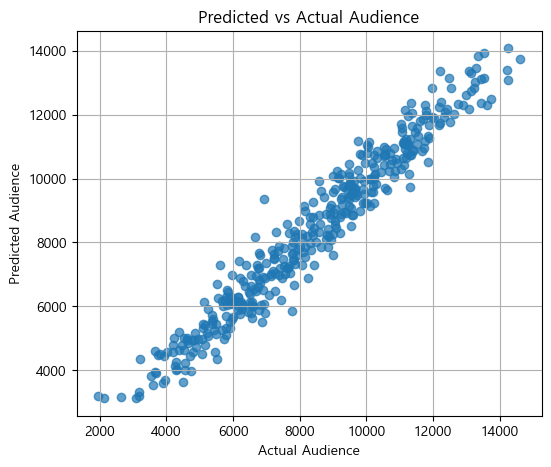

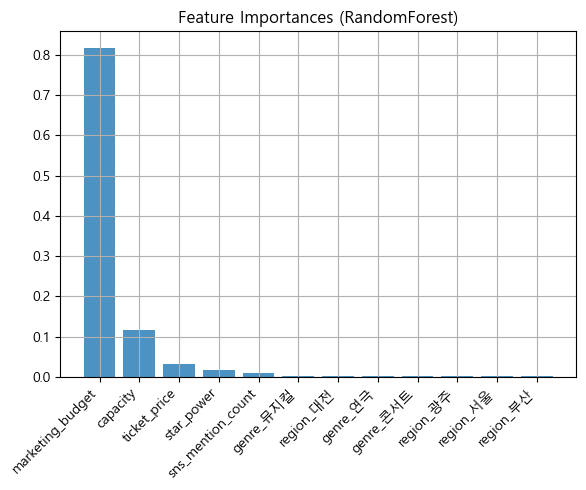

In [19]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  

# (4-1) 예측 vs 실제 산점도
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("Predicted vs Actual Audience")
plt.xlabel("Actual Audience")
plt.ylabel("Predicted Audience")
plt.grid(True)
plt.show()

# (4-2) 중요 피처(Feature Importance) 시각화
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_cols[i] for i in sorted_idx]

plt.figure(figsize=(6, 5))
plt.bar(range(len(importances)), importances[sorted_idx], alpha=0.8)
plt.title("Feature Importances (RandomForest)")
plt.xticks(range(len(importances)), sorted_features, rotation=45, ha="right")
plt.tight_layout()
plt.grid(True)
plt.show()

In [20]:
def predict_audience(model, capacity, ticket_price, marketing_budget, sns_mention_count, star_power, genre, region):
    """
    입력 변수에 따른 공연 예상 관객 수를 예측하는 함수입니다.
    
    매개변수:
      - model: 학습된 회귀 모델 (RandomForestRegressor 등)
      - capacity: 공연장 좌석 수 (예: 1000)
      - ticket_price: 평균 티켓 가격 (예: 80000)
      - marketing_budget: 마케팅 예산 (단위: 만원, 예: 500)
      - sns_mention_count: SNS 언급량 (예: 300)
      - star_power: 출연진 '스타 파워' (1~5점, 예: 4)
      - genre: 공연 장르 (문자열, 예: "뮤지컬", "연극", "콘서트")
      - region: 공연 지역 (문자열, 예: "서울", "부산", "대전", "광주")
    
    반환값:
      - 예측된 관객 수 (실수)
    """
    # 미리 정의된 범주 목록 (학습 시 사용한 카테고리와 동일)
    genre_list = ["뮤지컬", "연극", "콘서트"]
    region_list = ["서울", "부산", "대전", "광주"]
    
    # 입력 변수에 대해 원-핫 인코딩 (각 카테고리별 변수 생성)
    features = {
        "capacity": capacity,
        "ticket_price": ticket_price,
        "marketing_budget": marketing_budget,
        "sns_mention_count": sns_mention_count,
        "star_power": star_power,
    }
    
    # 장르 변수: 예를 들어 'genre_뮤지컬', 'genre_연극', 'genre_콘서트'
    for g in genre_list:
        col_name = f"genre_{g}"
        features[col_name] = 1 if genre == g else 0

    # 지역 변수: 예를 들어 'region_서울', 'region_부산', 'region_대전', 'region_광주'
    for r in region_list:
        col_name = f"region_{r}"
        features[col_name] = 1 if region == r else 0

    # DataFrame으로 변환 (모델 입력 형식에 맞춤)
    import pandas as pd
    input_df = pd.DataFrame([features])
    
    # 예측 수행
    prediction = model.predict(input_df)[0]
    return prediction

# 예시 사용법:
# (아래 변수들은 사용자가 입력하는 값입니다.)
sample_capacity = 2000
sample_ticket_price = 75000
sample_marketing_budget = 800  # 단위: 만원
sample_sns_mention_count = 1200
sample_star_power = 4
sample_genre = "연극"
sample_region = "서울"

# 학습된 모델 (model)이 이미 생성되어 있다고 가정
predicted_audience = predict_audience(model, sample_capacity, sample_ticket_price, 
                                      sample_marketing_budget, sample_sns_mention_count, 
                                      sample_star_power, sample_genre, sample_region)

print(f"예상 관객 수: {predicted_audience:.0f}명")

예상 관객 수: 6284명


In [24]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import gradio as gr

# --- 1. 샘플 데이터 생성 (역사 데이터 포함) ---
def generate_sample_data(n=200, random_state=42):
    random.seed(random_state)
    np.random.seed(random_state)
    
    performance_ids = list(range(1, n+1))
    possible_genres = ["뮤지컬", "연극", "콘서트"]
    genres = [random.choice(possible_genres) for _ in range(n)]
    
    possible_regions = ["서울", "부산", "대전", "광주"]
    regions = [random.choice(possible_regions) for _ in range(n)]
    
    capacities = np.random.choice([500, 1000, 2000, 3000, 5000], size=n)
    ticket_prices = np.random.randint(30000, 100001, size=n)  # 3만원 ~ 10만원
    marketing_budgets = np.random.randint(200, 3001, size=n)    # 200만원 ~ 3000만원
    sns_mention_counts = np.random.randint(50, 5001, size=n)
    star_powers = np.random.randint(1, 6, size=n)               # 1~5점
    
    # 간단한 기준 수식과 노이즈를 이용해 실제 관객 수 산출
    base = 0.6 * capacities + 0.02 * ticket_prices + 3.0 * marketing_budgets + 300 * star_powers
    noise = np.random.normal(loc=0, scale=500, size=n)
    actual_audiences = base + noise

    data = pd.DataFrame({
        "performance_id": performance_ids,
        "genre": genres,
        "region": regions,
        "capacity": capacities,
        "ticket_price": ticket_prices,
        "marketing_budget": marketing_budgets,
        "sns_mention_count": sns_mention_counts,
        "star_power": star_powers,
        "actual_audience": actual_audiences
    })
    # 날짜: 2023-01-01부터 하루씩 증가
    data["date"] = pd.date_range(start="2023-01-01", periods=n, freq="D")
    return data

# 생성된 샘플 역사 데이터 (대시보드 내 과거 비교용)
df_historical = generate_sample_data(n=200, random_state=42)

# --- 2. 데이터 전처리 및 모델 학습 (이전 코드 참고) ---
# 여기서는 앞서 학습된 모델이 있다고 가정합니다.
# 만약 모델이 없다면 아래 코드를 실행하여 학습하세요.
def preprocess_and_train(df):
    df = df.copy()
    df.drop_duplicates(subset="performance_id", inplace=True)
    # 원-핫 인코딩 (모든 카테고리 생성)
    df_encoded = pd.get_dummies(df, columns=["genre", "region"], drop_first=False)
    
    global feature_cols
    feature_cols = [
        "capacity",
        "ticket_price",
        "marketing_budget",
        "sns_mention_count",
        "star_power",
        "genre_뮤지컬", "genre_연극", "genre_콘서트",
        "region_서울", "region_부산", "region_대전", "region_광주"
    ]
    X = df_encoded[feature_cols]
    y = df_encoded["actual_audience"]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# 학습된 모델 (전역 변수)
model = preprocess_and_train(df_historical)

# --- 3. 예측 함수 (예측값 및 예측 구간) ---
def predict_audience(model, capacity, ticket_price, marketing_budget, sns_mention_count, star_power, genre, region):
    genre_list = ["뮤지컬", "연극", "콘서트"]
    region_list = ["서울", "부산", "대전", "광주"]
    
    features = {
        "capacity": capacity,
        "ticket_price": ticket_price,
        "marketing_budget": marketing_budget,
        "sns_mention_count": sns_mention_count,
        "star_power": star_power,
    }
    for g in genre_list:
        features[f"genre_{g}"] = 1 if genre == g else 0
    for r in region_list:
        features[f"region_{r}"] = 1 if region == r else 0
    input_df = pd.DataFrame([features])
    # 전체 모델 예측 (평균)
    prediction = model.predict(input_df)[0]
    # 개별 트리 예측을 통해 예측 구간 산출 (5% ~ 95% 퍼센타일)
    tree_preds = np.array([estimator.predict(input_df)[0] for estimator in model.estimators_])
    lower = np.percentile(tree_preds, 5)
    upper = np.percentile(tree_preds, 95)
    return prediction, lower, upper

# --- 4. Gradio 통합 대시보드 함수 ---
def gradio_predict_dashboard(capacity, ticket_price, marketing_budget, sns_mention_count, star_power, genre, region, actual_audience):
    # 4-1. 예측값 및 구간 계산
    pred, lower, upper = predict_audience(model, capacity, ticket_price, marketing_budget, sns_mention_count, star_power, genre, region)
    
    # 4-2. ROI 및 BEP 계산 (비용 가정: production_cost = capacity * 10,000, marketing_cost = marketing_budget * 10,000)
    production_cost = capacity * 10000
    marketing_cost = marketing_budget * 10000
    total_cost = production_cost + marketing_cost
    revenue = pred * ticket_price
    roi = (revenue - total_cost) / total_cost * 100  # ROI (%)
    bep_audience = total_cost / ticket_price         # 손익분기점
    
    summary = f"예상 관객 수: {pred:.0f}명 ({lower:.0f} ~ {upper:.0f}명)\n"
    if actual_audience is not None and actual_audience > 0:
        error_rate = abs(pred - actual_audience) / actual_audience * 100
        summary += f"오차율: {error_rate:.2f}%\n"
    else:
        summary += "(실제 관객 수 미입력: 오차율 계산 불가)\n"
    summary += f"ROI: {roi:.2f}%\n손익분기점(BEP): {bep_audience:.0f}명\n"
    
    # 4-3. 민감도 분석: 마케팅 예산 변화에 따른 예상 관객 수 변화
    mb_values = np.linspace(marketing_budget * 0.5, marketing_budget * 1.5, 20)
    preds_sensitivity = []
    for mb in mb_values:
        features = {
            "capacity": capacity,
            "ticket_price": ticket_price,
            "marketing_budget": mb,
            "sns_mention_count": sns_mention_count,
            "star_power": star_power,
        }
        for g in ["뮤지컬", "연극", "콘서트"]:
            features[f"genre_{g}"] = 1 if genre == g else 0
        for r in ["서울", "부산", "대전", "광주"]:
            features[f"region_{r}"] = 1 if region == r else 0
        input_df_temp = pd.DataFrame([features])
        pred_temp = model.predict(input_df_temp)[0]
        preds_sensitivity.append(pred_temp)
    fig1, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(mb_values, preds_sensitivity, marker='o')
    ax1.set_title("민감도 분석: 마케팅 예산 변화에 따른 예상 관객 수")
    ax1.set_xlabel("마케팅 예산 (만원)")
    ax1.set_ylabel("예상 관객 수")
    ax1.grid(True)
    
    # 4-4. Feature Importance Plot
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_idx]
    fig2, ax2 = plt.subplots(figsize=(6,4))
    ax2.bar(range(len(importances)), importances[sorted_idx], alpha=0.8)
    ax2.set_title("Feature Importances")
    ax2.set_xticks(range(len(importances)))
    ax2.set_xticklabels(sorted_features, rotation=45, ha="right")
    ax2.grid(True)
    fig2.tight_layout()
    
    # 4-5. Historical Time Series Plot: 실제 vs 예측 (역사 데이터 사용)
    # 전처리: df_historical에 대해 원-핫 인코딩 적용
    df_hist = df_historical.copy()
    df_hist_encoded = pd.get_dummies(df_hist, columns=["genre", "region"], drop_first=False)
    # 학습 시 사용한 feature_cols가 모두 존재하도록 보완
    for col in feature_cols:
        if col not in df_hist_encoded.columns:
            df_hist_encoded[col] = 0
    X_hist = df_hist_encoded[feature_cols]
    df_hist["predicted_audience"] = model.predict(X_hist)
    df_hist = df_hist.sort_values("date")
    fig3, ax3 = plt.subplots(figsize=(8,4))
    ax3.plot(df_hist["date"], df_hist["actual_audience"], label="Actual Audience", marker='o')
    ax3.plot(df_hist["date"], df_hist["predicted_audience"], label="Predicted Audience", marker='o')
    ax3.set_title("Historical Actual vs Predicted Audience")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Audience")
    ax3.legend()
    ax3.grid(True)
    fig3.autofmt_xdate()
    
    return summary, fig1, fig2, fig3

# --- 5. Gradio 인터페이스 구성 ---
iface = gr.Interface(
    fn=gradio_predict_dashboard,
    inputs=[
        gr.Number(label="Capacity (공연장 좌석수)"),               # 예: 2000
        gr.Number(label="Ticket Price (평균 티켓 가격)"),            # 예: 75000
        gr.Number(label="Marketing Budget (마케팅 예산, 만원)"),       # 예: 800
        gr.Number(label="SNS Mention Count (SNS 언급량)"),           # 예: 1200
        gr.Number(label="Star Power (1~5)"),                         # 예: 4
        gr.Dropdown(choices=["뮤지컬", "연극", "콘서트"], label="Genre"),
        gr.Dropdown(choices=["서울", "부산", "대전", "광주"], label="Region"),
        gr.Number(label="Actual Audience (실제 관객 수, 선택)", value=None)
    ],
    outputs=[
        gr.Textbox(label="예측 요약"),
        gr.Plot(label="민감도 분석"),
        gr.Plot(label="Feature Importance"),
        gr.Plot(label="Historical Comparison")
    ],
    title="공연 관객 수 예측 및 대시보드",
    description="입력한 공연 변수에 따라 예상 관객 수, 예측 구간, ROI, BEP를 계산하고, 민감도 분석, 주요 변수 영향, 과거 데이터 비교 등 다양한 분석 결과를 제공합니다."
)

iface.launch()



* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\U